## Example panan-rOM3 analysis notebook

For `8km_jra_ryf_obc_Charrassin` experiment (MOM6-CICE6 panan 1/12th degree ~ 4km with no ice shelves)

**Note** Several non-standard uses of `esm_datastore`:

- `esm_datastore` was generated with a different branch to main to pick up incorrectly named files (see https://github.com/ACCESS-NRI/access-nri-intake-catalog/issues/459, thanks to Charles Turner for fixing this for me)
- Years 9 and 10 of this run used parallelised IO, and unfortunately the tiling resulted in NaNs along part of the y axis in these files. Therefore, we must use a preprocessing function that replaces these axes with that of an earlier time (month 0) (thanks to Jemma Jeffree for her help with this!)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
import intake
import cmocean as cm

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37955,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:42461,Total threads: 1
Dashboard: /proxy/45073/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:45643,


Load datastore

In [3]:
esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/archive/8km_jra_ryf_obc_Charrassin/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

,unique
filename,608
file_id,44
path,5088
filename_timestamp,131
frequency,3
start_date,240
end_date,241
variable,201
variable_long_name,183
variable_standard_name,39


List available diagnostics

In [4]:
variables = esm_datastore.unique().variable
print(variables)

['ANGLE', 'ANGLET', 'NCAT', 'VGRDa', 'VGRDb', 'VGRDi', 'VGRDs', 'aice', 'blkmask', 'congel', 'dvidtd', 'dvidtt', 'frazil', 'frzmlt', 'hi', 'hs', 'sifb', 'snoice', 'time', 'time_bounds', 'uvel', 'vvel', 'Tair_m', 'Tsfc_m', 'aice_m', 'aicen_m', 'albice_m', 'albsni_m', 'albsno_m', 'alidf_ai_m', 'alidr_ai_m', 'alvdf_ai_m', 'alvdr_ai_m', 'congel_m', 'daidtd_m', 'daidtt_m', 'divu_m', 'dvidtd_m', 'dvidtt_m', 'evap_ai_m', 'fcondtop_ai_m', 'fcondtopn_ai_m', 'fhocn_ai_m', 'flat_ai_m', 'flatn_ai_m', 'flwdn_m', 'flwup_ai_m', 'fmeltt_ai_m', 'fmelttn_ai_m', 'frazil_m', 'fresh_ai_m', 'frzmlt_m', 'fsalt_ai_m', 'fsalt_m', 'fsens_ai_m', 'fsensn_ai_m', 'fsurfn_ai_m', 'fswabs_ai_m', 'fswdn_m', 'fswthru_ai_m', 'fswup_m', 'hi_m', 'hs_m', 'ice_present_m', 'meltb_m', 'meltl_m', 'melts_m', 'meltt_m', 'opening_m', 'rain_ai_m', 'scale_factor_m', 'shear_m', 'sice_m', 'sifb_m', 'snoice_m', 'snow_ai_m', 'strairx_m', 'strairy_m', 'strcorx_m', 'strcory_m', 'strength_m', 'strintx_m', 'strinty_m', 'strocnx_m', 'strocny

Load month 0 specific datastore to get y axis info

In [5]:
mo0_esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/datastores/8km_jra_ryf_obc_Charrassin-output000/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

ds_good_yh = mo0_esm_datastore.search(variable="umo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yh_coords = ds_good_yh.yh.copy().load()
ds_good_yq = mo0_esm_datastore.search(variable="vmo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yq_coords = ds_good_yq.yq.copy().load()
def reset_y_coords(ds): #thanks to Jemma Jeffree for helping make this work!!
    ds = ds.assign_coords({'yh':good_yh_coords})
    ds = ds.assign_coords({'yq':good_yq_coords})
    return ds

When loading data that has a y-axis, you need to use the `preprocess` (and likely `decode_timedelta` too) arguments:
```
esm_datastore.search(variable="").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})
```

For example:

In [6]:
esm_datastore.search(variable="SSH").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})


<xarray.Dataset> Size: 3GB
Dimensions:  (time: 120, yh: 1442, xh: 4320)
Coordinates:
  * xh       (xh) float64 35kB -280.0 -279.9 -279.8 -279.7 ... 79.79 79.88 79.96
  * time     (time) object 960B 1900-01-16 12:00:00 ... 1909-12-16 12:00:00
  * yh       (yh) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
Data variables:
    SSH      (time, yh, xh) float32 3GB dask.array<chunksize=(1, 287, 434), meta=np.ndarray>
Attributes: (12/16)
    NumFilesInSet:                            1
    title:                                    ACCESS-OM3
    associated_files:                         areacello: access-om3.mom6.stat...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['SSH']
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   area:mean yh:mean xh:mean time:...
    intake_esm_attrs:variable_units:          m,days,days since 1900-01-01 00...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_mom6_2d_SSH_1mon_mea...

In [7]:
esm_datastore.search(variable="vo").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})


<xarray.Dataset> Size: 224GB
Dimensions:  (time: 120, z_l: 75, yq: 1443, xh: 4320)
Coordinates:
  * xh       (xh) float64 35kB -280.0 -279.9 -279.8 -279.7 ... 79.79 79.88 79.96
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time     (time) object 960B 1900-01-16 12:00:00 ... 1909-12-16 12:00:00
  * yq       (yq) float64 12kB -86.5 -86.48 -86.46 ... -37.59 -37.53 -37.46
Data variables:
    vo       (time, z_l, yq, xh) float32 224GB dask.array<chunksize=(1, 15, 144, 217), meta=np.ndarray>
Attributes: (12/18)
    NumFilesInSet:                            1
    title:                                    ACCESS-OM3
    associated_files:                         areacello: access-om3.mom6.stat...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['vo']
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ideal_age_tracer,,,,,,,sea_wate...
    intake_esm_attrs:variable_cell_methods:   area:mean z_l:mean yh:mean xh:m...
    intake_esm_attrs:variable_units:          yr,days,days since 1900-01-01 0...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_month_z.1mon

### Loading other model data from the intake catalogue for comparison

Let's load in the mom6 panan01 and panan005 models, as well as ACCESS-OM2-01-RYF (potentially there is a more suitable one with more diagnostics starting from WOA but it's not on intake?)

In [8]:
catalog = intake.cat.access_nri

In [9]:
catalog.search(model="ACCESS-OM2-01", frequency="1mon",name="01deg_jra55v13_ryf9091")


,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{ocean, seaIce}",{1mon},"{salt_surface_ave, fsalt_m, total_ocean_evap_heat, scalar_axis, flatn_ai_m, TLON, total_ocean_calving_heat, ANGLET, lprec, pbot_t, fswup_m, sfc_hflux_pme, total_ocean_hflux_coupler, uatm_m, ULON, ..."


In [10]:
'''
names of panant models
panant-01-zstar-ACCESSyr2
panant-005-zstar-ACCESSyr2
panant-0025-zstar-ACCESSyr2
'''
catalog.search(name = "panant-01-zstar-ACCESSyr2")


,model,description,realm,frequency,variable
name,,,,,
panant-01-zstar-ACCESSyr2,"{MOM6, SIS2}",{0.1 degree (MOM6+SIS2) Pan-Antarctic regional model configuration under 1990-1991 JRA55-do repeat year forcing.},"{ocean, seaIce}","{1day, 1mon, fx}","{rhopot2, dyCv, tauy, intz_gKEu_2d, umo_2d, geolat_c, geolon_c, dxCv, fsitherm, intz_v_BT_accel_2d, vmo_2d, hf_dudt_2d, diffu, IY_TRANS, diffv, tob, intz_rvxu_2d, intz_diffv_2d, geolat, wet_u, int..."


# Plot surface velocity magnitude averaged over year 10

### Have to define specific chunking settings

In [11]:
# define chunks dict
chunks_dict = {
	        'time' : 1,
	        'yq' : 1443,
	        'xq' : 4321,
            'yh':1442,
            'xh':4320
	    }

### Load the data file for year 10.

In [12]:
# need to say what chunks are in the xarray_open_kwargs
panantrom3_vo = esm_datastore.search(variable="vo", frequency = '1mon').to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True,'chunks' : chunks_dict},)

panantrom3_uo = esm_datastore.search(variable="uo", frequency = '1mon').to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True,'chunks' : chunks_dict},)

In [13]:
# load an ocean_month_z file which has all the grid info
panantrom3_ds = xr.open_mfdataset('/g/data/ol01/cy8964/access-om3/archive/8km_jra_ryf_obc_Charrassin/output114/ocean_month_z.nc',
	                                  preprocess=reset_y_coords, decode_timedelta = False, chunks = chunks_dict)

### Prepare the grid and interpolate

In [14]:
from xgcm import Grid
grid = Grid(panantrom3_ds.isel(time = 0).drop_vars('time'),coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"z_l","outer":"z_i"}},periodic="x")


panantrom3_vo_interp = grid.interp(panantrom3_vo.vo,'y',boundary='extend')
panantrom3_uo_interp = grid.interp(panantrom3_uo.uo,'x',boundary='extend')



/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


### Make velocity magnitude

In [15]:
panantrom3_velmag = (panantrom3_vo_interp**2 + panantrom3_uo_interp**2)**0.5
panantrom3_velmagSurf = panantrom3_velmag.isel(time=slice(-12,None)).mean(dim='time').isel(z_l=0)

### Make example plot

(-78.0, -63.0)

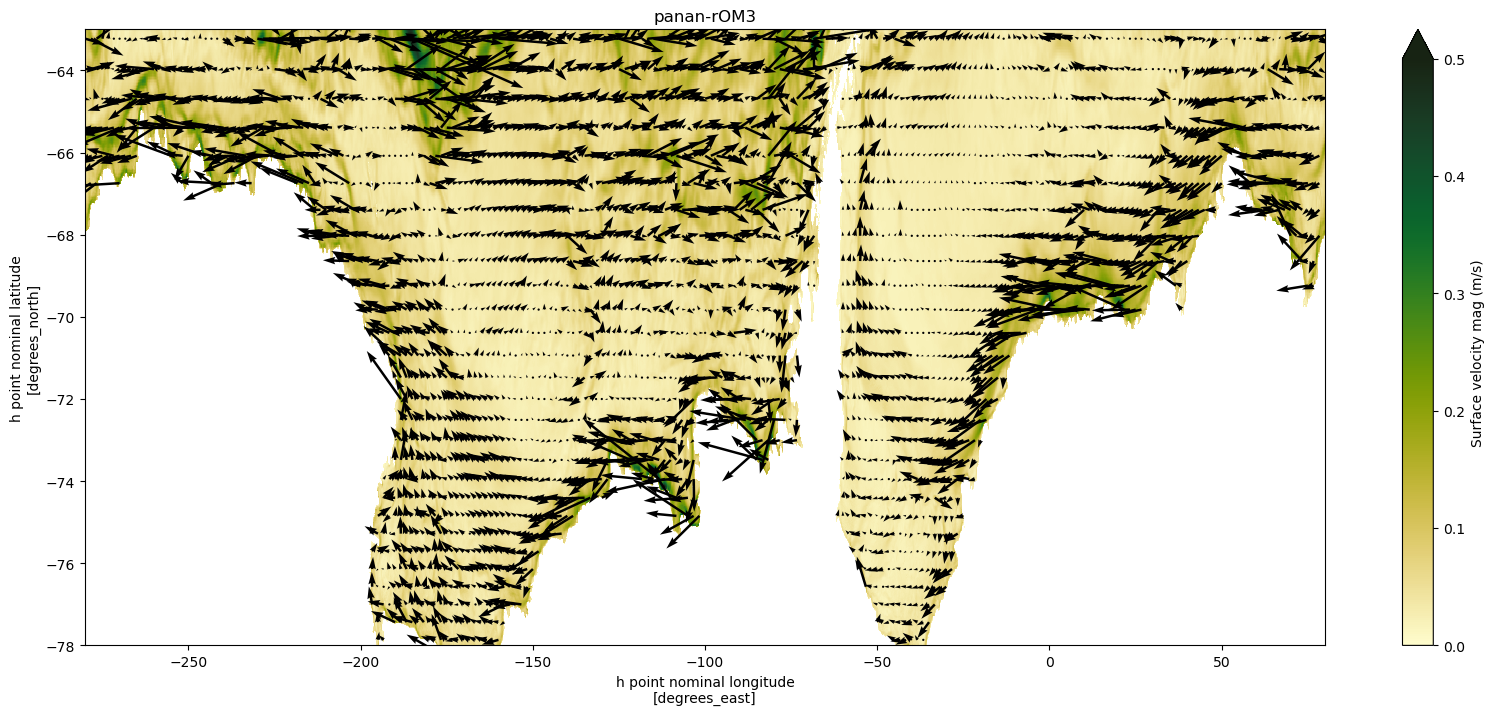

In [21]:

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20,8))
ax = np.ravel(axes)
vmax = 0.5
vmin = 0
cmap = cm.cm.speed

panantrom3_velmagSurf.plot(ax = ax[0], vmax = vmax, vmin = vmin, cmap = cmap, 
                    cbar_kwargs = {'label':'Surface velocity mag (m/s)'})
# ax[0].streamplot(panantrom3_uo_interp.xh.values, panantrom3_vo_interp.yh.values, 
#                  panantrom3_uo_interp.isel(time=slice(-12,None)).mean(dim='time').isel(z_l=0).values, 
#                  panantrom3_vo_interp.isel(time=slice(-12,None)).mean(dim='time').isel(z_l=0).values)
step=20
ax[0].quiver(panantrom3_uo_interp.xh[::step].values, panantrom3_vo_interp.yh[::step].values, 
                 panantrom3_uo_interp.isel(time=slice(-12,None)).mean(dim='time').isel(z_l=0)[::step,::step].values, 
                 panantrom3_vo_interp.isel(time=slice(-12,None)).mean(dim='time').isel(z_l=0)[::step,::step].values,scale=5,width=0.002,headwidth=3)
ax[0].set_title('panan-rOM3')
ax[0].set_ylim([-78,-63])

### Load other data

In [43]:
catalog

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55_ryf_Control,{ACCESS-OM2-01},"{0.1° ACCESS-OM2 repeat year forcing control run for the simulations performed in Huguenin et al. (2024, GRL)}","{ocean, seaIce}","{1mon, fx}","{salt_surface_ave, fsalt_m, kmt, total_ocean_evap_heat, scalar_axis, flatn_ai_m, TLON, total_ocean_calving_heat, ANGLET, fswup_m, uatm_m, sfc_hflux_pme, total_ocean_hflux_coupler, ULON, temp_vdiff..."
01deg_jra55_ryf_ENFull,{ACCESS-OM2},"{0.1° ACCESS-OM2 El Níño run for the simulations performed in Huguenin et al. (2024, GRL)}","{ocean, seaIce}","{1mon, fx}","{salt_surface_ave, fsalt_m, kmt, total_ocean_evap_heat, scalar_axis, flatn_ai_m, TLON, total_ocean_calving_heat, ANGLET, fswup_m, uatm_m, sfc_hflux_pme, total_ocean_hflux_coupler, ULON, temp_vdiff..."
01deg_jra55_ryf_LNFull,{ACCESS-OM2},"{0.1° ACCESS-OM2 La Níña run for the simulations performed in Huguenin et al. (2024, GRL)}","{ocean, seaIce}","{1mon, fx}","{salt_surface_ave, fsalt_m, kmt, total_ocean_evap_heat, scalar_axis, flatn_ai_m, TLON, total_ocean_calving_heat, ANGLET, fswup_m, uatm_m, sfc_hflux_pme, total_ocean_hflux_coupler, ULON, temp_vdiff..."
01deg_jra55v13_ryf9091,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{ocean, seaIce}","{1day, 1mon, fx, 3hr, 3mon}","{salt_surface_ave, fsalt_m, kmt, total_ocean_evap_heat, scalar_axis, flatn_ai_m, TLON, vsurf, total_ocean_calving_heat, ANGLET, lprec, pbot_t, fswup_m, sfc_hflux_pme, total_ocean_hflux_coupler, ua..."
01deg_jra55v13_ryf9091_easterlies_down10,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and zonal/meridional wind speed around Antarctica decreased by 10%.},"{ocean, seaIce}","{1day, 1mon, fx}","{salt_surface_ave, fsalt_m, kmt, total_ocean_evap_heat, scalar_axis, flatn_ai_m, TLON, vsurf, total_ocean_calving_heat, ANGLET, lprec, pbot_t, fswup_m, sfc_hflux_pme, total_ocean_hflux_coupler, ua..."
01deg_jra55v13_ryf9091_easterlies_up10,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and zonal/meridional wind speed around Antarctica increased by 10%.},"{ocean, seaIce}","{1day, 1mon, fx}","{salt_surface_ave, fsalt_m, kmt, total_ocean_evap_heat, scalar_axis, flatn_ai_m, TLON, vsurf, total_ocean_calving_heat, ANGLET, lprec, pbot_t, fswup_m, sfc_hflux_pme, total_ocean_hflux_coupler, ua..."
01deg_jra55v13_ryf9091_easterlies_up10_meridional,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and meridional wind speed around Antarctica increased by 10%.},"{ocean, seaIce}","{1day, 1mon, fx}","{salt_surface_ave, fsalt_m, kmt, total_ocean_evap_heat, scalar_axis, flatn_ai_m, TLON, vsurf, total_ocean_calving_heat, ANGLET, lprec, pbot_t, fswup_m, sfc_hflux_pme, total_ocean_hflux_coupler, ua..."
01deg_jra55v13_ryf9091_easterlies_up10_zonal,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and zonal wind speed around Antarctica increased by 10%.},"{ocean, seaIce}","{1day, 1mon, fx}","{salt_surface_ave, fsalt_m, kmt, total_ocean_evap_heat, scalar_axis, flatn_ai_m, TLON, vsurf, total_ocean_calving_heat, ANGLET, lprec, pbot_t, fswup_m, sfc_hflux_pme, total_ocean_hflux_coupler, ua..."
01deg_jra55v13_ryf9091_qian_wthmp,{ACCESS-OM2},"{Future perturbations with wind, thermal and meltwater forcing, branching off 01deg_jra55v13_ryf9091, as described in Li et al. 2023, https://www.nature.com/articles/s41586-023-05762-w}","{ocean, seaIce}","{1mon, fx}","{salt_surface_ave, fsalt_m, kmt, total_ocean_evap_heat, scalar_axis, flatn_ai_m, TLON, total_ocean_calving_heat, ANGLET, lprec, pbot_t, fswup_m, sfc_hflux_pme, total_ocean_hflux_coupler, uatm_m, U..."


In [37]:

# load old panan
panant01_uo = catalog["panant-01-zstar-ACCESSyr2"].search(variable="uo", frequency = '1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True}).uo
panant01_vo = catalog["panant-01-zstar-ACCESSyr2"].search(variable="vo", frequency = '1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True}).vo
##### load panant01_ds
panant005_uo = catalog["panant-005-zstar-ACCESSyr2"].search(variable="uo", frequency = '1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True}).uo
panant005_vo = catalog["panant-005-zstar-ACCESSyr2"].search(variable="vo", frequency = '1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True}).vo
##### load panant005_ds

# load access-om2-01
accessom2_uo = catalog["01deg_jra55v13_ryf9091"].search(frequency="1mon",variable = "u").to_dask(xarray_open_kwargs={'decode_timedelta':True}).u
accessom2_vo = catalog["01deg_jra55v13_ryf9091"].search(frequency="1mon",variable = "v").to_dask(xarray_open_kwargs={'decode_timedelta':True}).v

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

# NOTE: NEED TO FIND panant_01 and _005 ds to load grid information

### re-grid other data if required

In [ ]:
grid_pantant01 = Grid(panant01_ds.isel(time = 0).drop_vars('time'),coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"z_l","outer":"z_i"}},periodic="x")
grid_pantant005 = Grid(panant005_ds.isel(time = 0).drop_vars('time'),coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"z_l","outer":"z_i"}},periodic="x")

pantant01_uo_interp = grid_pantant01.interp(panant01_uo.uo,'y',boundary='extend')
pantant01_vo_interp = grid_pantant01.interp(panant01_vo.vo,'x',boundary='extend')


pantant005_uo_interp = grid_pantant005.interp(panant005_uo.uo,'y',boundary='extend')
pantant005_vo_interp = grid_pantant005.interp(panant005_vo.vo,'x',boundary='extend')

### make velocity magnitudes

In [ ]:
pantant01_velmag = (pantant01_vo_interp**2 + pantant01_uo_interp**2)**0.5
pantant01_velmagSurf = pantant01_velmag.isel(time=slice(-12,None)).mean(dim='time').isel(z_l=0)

pantant005_velmag = (pantant005_vo_interp**2 + pantant005_uo_interp**2)**0.5
pantant005_velmagSurf = pantant005_velmag.isel(time=slice(-12,None)).mean(dim='time').isel(z_l=0)

accessom2_velmag = (accessom2_uo**2 + accessom2_vo**2)**0.5
accessom2_velmagSurf = accessom2_velmag.isel(time=slice(-12,None)).mean(dim='time').isel(z_l=0)

### now make plots

In [ ]:

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20,8))
ax = np.ravel(axes)
vmax = 0.5
vmin = 0
cmap = cm.cm.speed

panantrom3_velmagSurf.plot(ax = ax[0], vmax = vmax, vmin = vmin, cmap = cmap, 
                    cbar_kwargs = {'label':'Surface velocity mag (m/s)'})
# ax[0].streamplot(panantrom3_uo_interp.xh.values, panantrom3_vo_interp.yh.values, 
#                  panantrom3_uo_interp.isel(time=slice(-12,None)).mean(dim='time').isel(z_l=0).values, 
#                  panantrom3_vo_interp.isel(time=slice(-12,None)).mean(dim='time').isel(z_l=0).values)
step=20
ax[0].quiver(panantrom3_uo_interp.xh[::step].values, panantrom3_vo_interp.yh[::step].values, 
                 panantrom3_uo_interp.isel(time=slice(-12,None)).mean(dim='time').isel(z_l=0)[::step,::step].values, 
                 panantrom3_vo_interp.isel(time=slice(-12,None)).mean(dim='time').isel(z_l=0)[::step,::step].values,scale=5,width=0.002,headwidth=3)
ax[0].set_title('panan-rOM3')
ax[0].set_ylim([-78,-63])

Text(0.5, 0.98, 'Annual Mean Mixed Layer Depth in year 10')

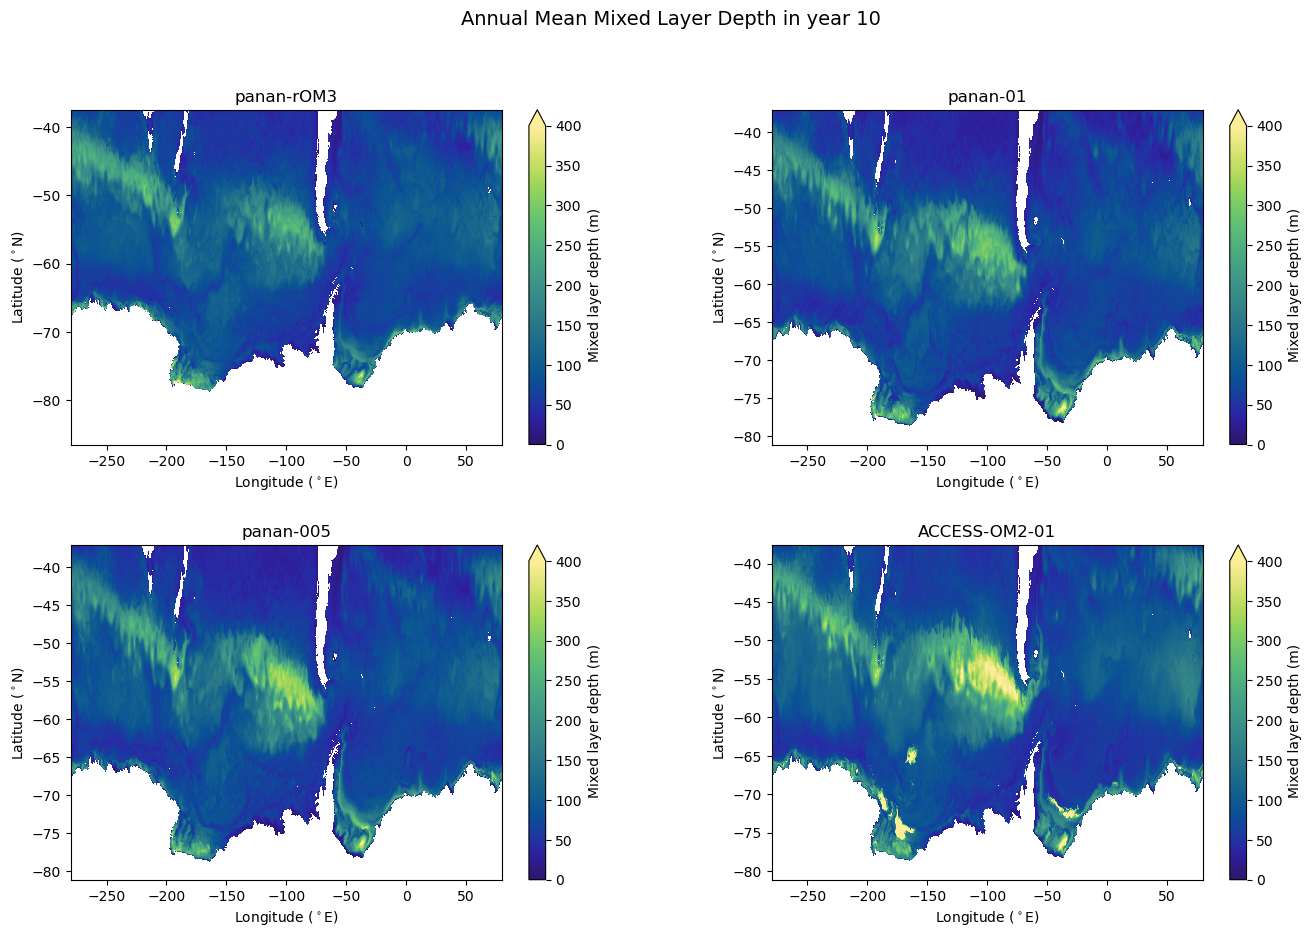

In [14]:
# now plot together

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16,10))
ax = np.ravel(axes)
vmax = 0.5
vmin = 0
cmap = cm.cm.speed

panantrom3_velmagSurf.plot(ax = ax[0], vmax = vmax, vmin = vmin, cmap = cmap, 
                    cbar_kwargs = {'label':'Surface velocity mag (m/s)'})
ax[0].set_title('panan-rOM3')

pantant01_velmagSurf.plot(ax = ax[1], vmax = vmax, vmin = vmin, cmap = cmap, 
                    cbar_kwargs = {'label':'Surface velocity mag (m/s)'})
ax[1].set_title('panan-01')

pantant005_velmagSurf.plot(ax = ax[2], vmax = vmax, vmin = vmin, cmap = cmap, 
                    cbar_kwargs = {'label':'Surface velocity mag (m/s)'})
ax[2].set_title('panan-005')

accessom2_velmagSurf.sel(yt_ocean = slice(-90,-37.6)).plot(ax = ax[3], vmax = vmax, vmin = vmin, cmap = cmap, 
                    cbar_kwargs = {'label':'Surface velocity mag (m/s)'})
ax[3].set_title('ACCESS-OM2-01')

for i in np.arange(len(ax)):
    ax[i].set_ylabel('Latitude ($^\circ$N)')
    ax[i].set_xlabel('Longitude ($^\circ$E)')

fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle('Annual Mean surface velocity magnitude in year 10', fontsize = 14)